In [ ]:
import os
from google.colab import drive

# Mount Google Drive to access the dataset
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Check if a GPU is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# Define data augmentation and preprocessing for training dataset
transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

# Preprocess the test dataset
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

train_path = "/content/drive/My Drive/nndlprojectdata/CAM16/train/data"
trainset = ImageFolder(root=train_path, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True, num_workers=2)

validation_path="/content/drive/My Drive/nndlprojectdata/CAM16/val/data"
validationset = ImageFolder(root=validation_path, transform=transform_test)
testloader = torch.utils.data.DataLoader(validationset, batch_size=32, shuffle=True, num_workers=2)



class BasicResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
            nn.BatchNorm2d(out_channels),
        )

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample is not None:
            identity = self.downsample(x)
        out += identity
        out = self.relu(out)
        return out

# Modify the model to use residual blocks


class NeuralNetwork(nn.Module):
    def __init__(self, block, num_blocks, num_classes=2):
        super(NeuralNetwork, self).__init__()
        self.in_channels = 32
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self.make_layer(block, 32, num_blocks[0], stride=1)
        self.layer2 = self.make_layer(block, 64, num_blocks[1], stride=2)
        self.layer3 = self.make_layer(block, 128, num_blocks[2], stride=2)
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(128, num_classes)


    def make_layer(self, block, out_channels, num_blocks, stride):
        layers = []
        layers.append(block(self.in_channels, out_channels, stride))
        self.in_channels = out_channels
        for _ in range(1, num_blocks):
            layers.append(block(out_channels, out_channels, stride=1))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x



# Initialize weights and add L2 regularization
def initialize_weights(layer):
    if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear):
        nn.init.kaiming_normal_(layer.weight, mode='fan_out', nonlinearity='relu')
        if layer.bias is not None:
            nn.init.zeros_(layer.bias)

net = NeuralNetwork(BasicResidualBlock, [2, 2, 2]).to(device)

# Initialize weights and add L2 regularization
net.apply(initialize_weights)

# Define loss function and optimizer with weight decay (L2 regularization)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=1e-4)  # Weight decay for regularization
scheduler = ReduceLROnPlateau(optimizer, 'max', patience=5, factor=0.5, verbose=True)

train_accuracy_list = []
train_loss_list = []
validation_accuracy_list = []
validation_loss_list = []

# Training loop
for epoch in range(50):
    running_loss = 0.0
    total = 0
    correct = 0
    net.train()  # Set the model to training mode
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = net(inputs)

        #print(outputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Calculate training accuracy in each iteration
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        train_accuracy = 100 * correct / total



    # Calculate validation accuracy and loss at the end of each epoch
    correct = 0
    total = 0
    validation_loss = 0.0
    net.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            loss = criterion(outputs, labels)
            validation_loss += loss.item()  # Accumulate validation loss
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    validation_accuracy = 100 * correct / total
    validation_accuracy_list.append(validation_accuracy)
    validation_loss /= len(testloader)  # Calculate average validation loss
    validation_loss_list.append(validation_loss)
    train_accuracy_list.append(train_accuracy)
    train_loss_list.append(loss.item())  # Store validation loss
    scheduler.step(validation_accuracy)

    print(f"Epoch {epoch + 1},Training Accuracy: {train_accuracy:.2f}%, "
          f"Training Loss: {train_loss_list[-1]:.4f}, Validation Accuracy: {validation_accuracy:.2f}%, "
          f"Validation Loss: {validation_loss:.4f}")

print("Finished Training")

Device: cuda:0
Epoch 1,Training Accuracy: 76.57%, Training Loss: 7.3560, Validation Accuracy: 50.00%, Validation Loss: 5.9843
Epoch 2,Training Accuracy: 78.97%, Training Loss: 0.9888, Validation Accuracy: 61.11%, Validation Loss: 0.8593
Epoch 3,Training Accuracy: 80.10%, Training Loss: 1.1222, Validation Accuracy: 81.48%, Validation Loss: 0.6886
Epoch 4,Training Accuracy: 85.14%, Training Loss: 0.8213, Validation Accuracy: 73.15%, Validation Loss: 0.6068
Epoch 5,Training Accuracy: 86.02%, Training Loss: 0.2093, Validation Accuracy: 82.41%, Validation Loss: 0.3830
Epoch 6,Training Accuracy: 85.39%, Training Loss: 0.1218, Validation Accuracy: 81.48%, Validation Loss: 0.3526
Epoch 7,Training Accuracy: 87.91%, Training Loss: 0.2130, Validation Accuracy: 81.48%, Validation Loss: 0.3460
Epoch 8,Training Accuracy: 87.78%, Training Loss: 0.5157, Validation Accuracy: 78.70%, Validation Loss: 0.4505
Epoch 9,Training Accuracy: 87.03%, Training Loss: 0.3527, Validation Accuracy: 81.48%, Validation

In [ ]:
net.eval()
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

final_validation_accuracy = 100 * correct / total

print(f"\n Final Validation Accuracy: {final_validation_accuracy:.2f}%")


 Final Validation Accuracy: 90.74%


In [ ]:
print("Training Loss:",train_loss_list)
print("Training Accuracy:",train_accuracy_list)

print("Testing (Validation) Loss:",validation_loss_list)
print("Testing (Validation) Accuracy:",validation_accuracy_list)

torch.save(net.state_dict(), '/content/drive/My Drive/nndlprojectdata/CAM16/cam16_model.pth')

Training Loss: [7.355988025665283, 0.988832950592041, 1.122193694114685, 0.8212890625, 0.20933181047439575, 0.12175873667001724, 0.21301878988742828, 0.5157046318054199, 0.3526887893676758, 0.3474690616130829, 0.7987483143806458, 0.5499373078346252, 0.9728869795799255, 0.6113569140434265, 0.5991986393928528, 0.5330910086631775, 0.25819772481918335, 0.46779242157936096, 0.05717011168599129, 0.09065719693899155, 0.9973620772361755, 0.11703184992074966, 0.15822292864322662, 0.38417544960975647, 0.18832840025424957, 0.14174754917621613, 0.18277299404144287, 0.2357224076986313, 0.07274886965751648, 0.40621688961982727, 0.1947367936372757, 0.09506392478942871, 0.13625071942806244, 0.1112123653292656, 0.10394427925348282, 0.4061201810836792, 0.15847037732601166, 0.3699904680252075, 0.31333544850349426, 0.5293605327606201, 0.14173594117164612, 0.20782049000263214, 0.1140534058213234, 0.23342275619506836, 0.14605475962162018, 0.020290452986955643, 0.1395658403635025, 0.061846792697906494, 0.188

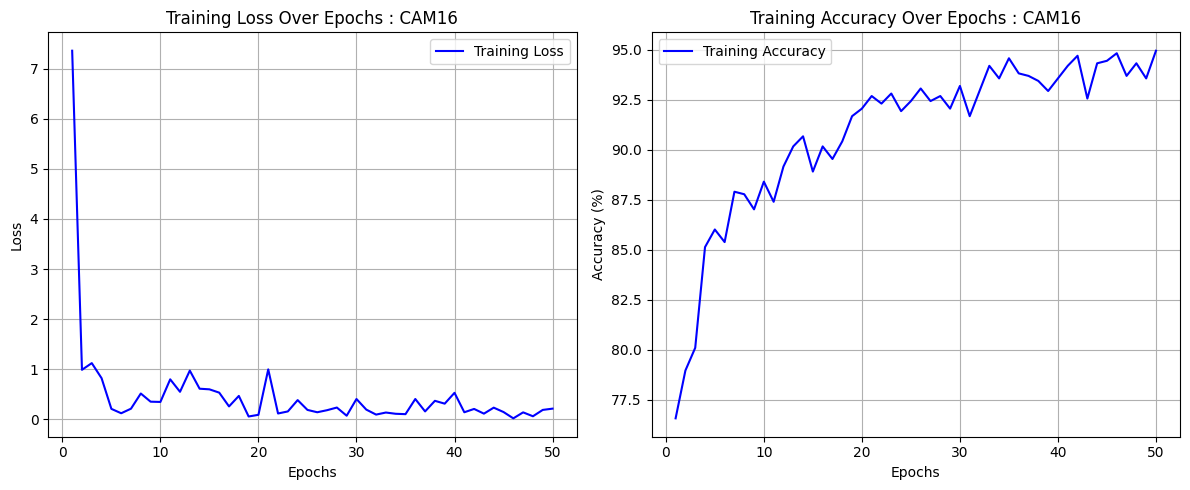

In [ ]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy and loss

epochs1 = range(1, len(train_accuracy_list) + 1)

# Create a list of epoch numbers (e.g., [1, 2, 3, ..., num_epochs])
epochs = list(range(1, len(epochs1) + 1))

# Create a 2x2 grid of subplots
plt.figure(figsize=(12, 5))

# Subplot 1: Training Accuracy (Blue)
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss_list, label='Training Loss', color='blue')
plt.title('Training Loss Over Epochs : CAM16')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Subplot 2: Validation Accuracy (Orange)
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy_list, label='Training Accuracy', color='blue')
plt.title('Training Accuracy Over Epochs : CAM16')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

# Adjust layout for better spacing
plt.tight_layout()

# Show the combined plot
plt.show()

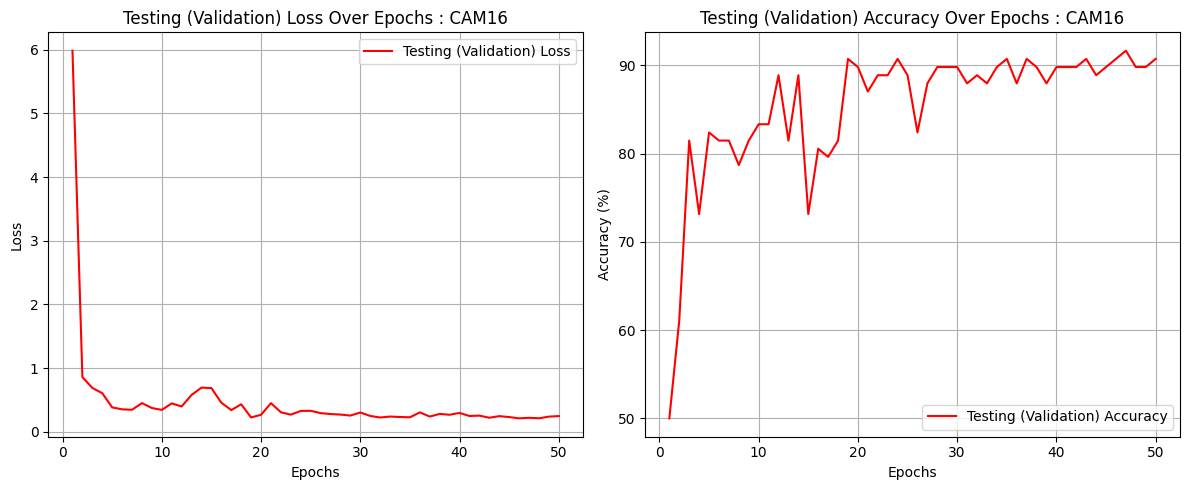

In [ ]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy and loss
epochs1 = range(1, len(train_accuracy_list) + 1)

# Create a list of epoch numbers (e.g., [1, 2, 3, ..., num_epochs])
epochs = list(range(1, len(epochs1) + 1))

# Create a 2x2 grid of subplots
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, validation_loss_list, label='Testing (Validation) Loss', color='Red')
plt.title('Testing (Validation) Loss Over Epochs : CAM16')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Subplot 4: Validation Loss (Red)
plt.subplot(1, 2, 2)
plt.plot(epochs, validation_accuracy_list, label='Testing (Validation) Accuracy', color='Red')
plt.title('Testing (Validation) Accuracy Over Epochs : CAM16')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

# Adjust layout for better spacing
plt.tight_layout()

# Show the combined plot
plt.show()

In [ ]:
# Save the training loss and accuracy
with open('/content/drive/My Drive/nndlprojectdata/CAM16/training_metrics.txt', 'w') as f:
    f.write("Training Loss: " + str(train_loss_list) + "\n")
    f.write("\nTraining Accuracy: " + str(train_accuracy_list) + "\n")

# Save the validation loss and accuracy
with open('/content/drive/My Drive/nndlprojectdata/CAM16/validation_metrics.txt', 'w') as f:
    f.write("Testing (Validation) Loss: " + str(validation_loss_list) + "\n")
    f.write("\nTesting (Validation) Accuracy: " + str(validation_accuracy_list) + "\n")